### Step 4. Exploratory data analysis (Python)
In addition to the data you retrieved in the previous tasks, you've been given a second file. 

You now have these two CSVs:
 - /datasets/project_sql_result_01.csv. It contains the following data:

company_name: taxi company name

trips_amount: the number of rides for each taxi company on November 15-16, 2017.
 - /datasets/project_sql_result_04.csv. It contains the following data:

dropoff_location_name: Chicago neighborhoods where rides ended

average_trips: the average number of rides that ended in each neighborhood in November 2017.

For these two datasets you now need to
- import the files
- study the data they contain
- make sure the data types are correct
- identify the top 10 neighborhoods in terms of drop-offs
- make graphs: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs
- draw conclusions based on each graph and explain the results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
query_result1 = "https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_01.csv"
query_result2 = "https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_04.csv"

In [3]:
trips_amount_df = pd.read_csv(query_result1)
avg_trips_df = pd.read_csv(query_result2)

In [4]:
trips_amount_df.sample(2)

,company_name,trips_amount
34,Norshore Cab,127
6,City Service,8448


In [5]:
avg_trips_df.sample(2)

,dropoff_location_name,average_trips
45,Boystown,53.966667
40,Bucktown,74.300000


In [6]:
trips_amount_df.isna().sum()

company_name    0
trips_amount    0
dtype: int64

In [7]:
trips_amount_df.isna().sum()

company_name    0
trips_amount    0
dtype: int64

In [8]:
len(avg_trips_df)*0.20

18.8

Identify the top 10 neighborhoods in terms of drop-offs.

In [9]:
avg_trips_df.nlargest(10, columns=["average_trips"])

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


Make graphs: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs

In [10]:
def plt_nlargest_pie(df, column, index, title="", top=10):
    data = df.nlargest(top, columns=[column]).set_index(index)  
    data.plot(kind='pie', y=column,autopct='%1.0f%%', figsize=(10, 5), legend=False).set(label=data.index)
    plt.title(title)
    plt.ylabel("")
    plt.show();

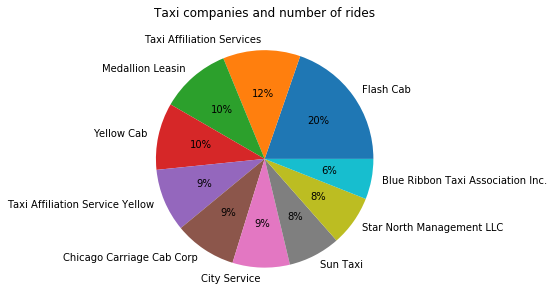

In [12]:
plt_nlargest_pie(trips_amount_df, column="trips_amount", index="company_name", title="Taxi companies and number of rides")

As we can see, the Flash Cab was very popular from November 15-16, 2017(Wednesday-Thursday), and the next one is Taxi Affiliation Services, and etc.

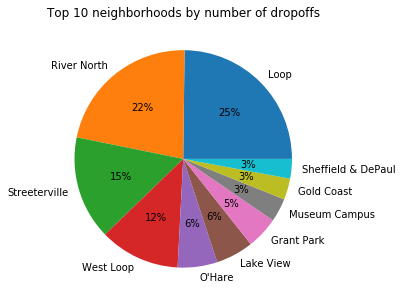

In [14]:
plt_nlargest_pie(avg_trips_df, column="average_trips", index="dropoff_location_name", title="Top 10 neighborhoods by number of dropoffs")

Loop, River North and Streeterville were neighborhoods with the highest average number of rides that ended in each neighborhood in November 2017.

In [15]:
top20_dropoff = avg_trips_df.nlargest(20, columns=["average_trips"])
others_dropoff = pd.DataFrame(dict(dropoff_location_name=["Others"],average_trips=[avg_trips_df[~avg_trips_df["dropoff_location_name"]
              .isin(top20_dropoff["dropoff_location_name"])]["average_trips"]
              .sum()]))

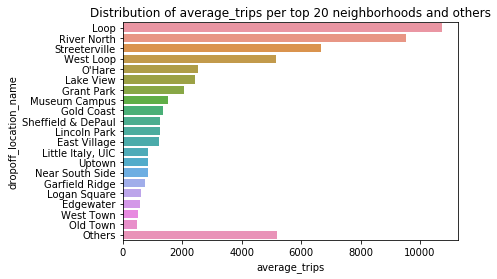

In [16]:
sns.set_color_codes("pastel")
sns.barplot(y="dropoff_location_name",x='average_trips', data=pd.concat([top20_dropoff, others_dropoff]))
sns.set_color_codes("muted")
plt.title("Distribution of average_trips per top 20 neighborhoods and others")
plt.show();

### Step 5. Testing hypotheses (Python)
- /datasets/project_sql_result_07.csv — the result of the last query. It contains data on rides from the Loop to O'Hare International Airport. Remember, these are the table's field values:

- start_ts
  - pickup date and time
- weather_conditions
  - weather conditions at the moment the ride started
- duration_seconds
  - ride duration in seconds

Test the hypothesis:

"The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

Decide where to set the significance level (alpha) on your own.

Explain:
- how you formed the null and alternative hypotheses
- what criterion you used to test the hypotheses and why


In [17]:
query_result3 = "https://code.s3.yandex.net/learning-materials/data-analyst-eng/project_sql_result_07.csv"

In [18]:
rides_df = pd.read_csv(query_result3)
rides_df.describe()

,duration_seconds
count,1068.000000
mean,2071.731273
std,769.461125
min,0.000000
25%,1438.250000
50%,1980.000000
75%,2580.000000
max,7440.000000


In [19]:
rides_df.isna().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

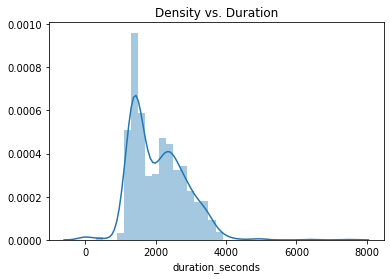

In [20]:
sns.distplot(rides_df["duration_seconds"], bins=list(range(100, 4000, 200)))
plt.title('Density vs. Duration');

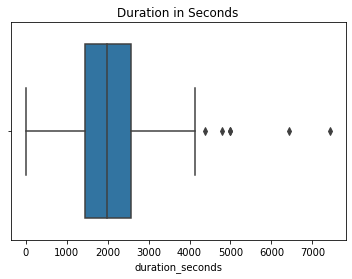

In [21]:
sns.boxplot(rides_df["duration_seconds"])
plt.title('Duration in Seconds');

In [22]:
rides_df["duration_seconds"].skew()

0.9146993095472892

In [23]:
rides_df["start_ts"] = pd.to_datetime(rides_df["start_ts"])

In [24]:
saturdays_bad_rides = rides_df[(rides_df["start_ts"].dt.weekday==5)&(rides_df["weather_conditions"]!="Good")]["duration_seconds"].values

In [25]:
saturdays_good_rides = rides_df[(rides_df["start_ts"].dt.weekday==5)&(rides_df["weather_conditions"]=="Good")]["duration_seconds"].values

In [26]:
len(saturdays_bad_rides), len(saturdays_good_rides)

(180, 888)

In [27]:
alpha = .05

Let's choose standard the significance level (actually it really depends on sample size, but anyway let's leave standard level) and let's state:

$H_0$="The average duration of rides from the Loop to O'Hare International Airport doesn't change"

$H_1$="The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

we will test by avg value and after that also will check both avg values

In [28]:
H_0 = "The average duration of rides from the Loop to O'Hare International Airport doesn't change"
H_1 = "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

In [29]:
result = stats.ttest_ind(saturdays_bad_rides, saturdays_good_rides)
print('pvalue:', result.pvalue)

if (result.pvalue < alpha):
    print(H_1)
else:
    print(H_0)
print("checking:")
print(f"bad weather, mean={saturdays_bad_rides.mean():.2f}")
print(f"good weather, mean={saturdays_good_rides.mean():.2f}")

pvalue: 6.517970327099473e-12
The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.
checking:
bad weather, mean=2427.21
good weather, mean=1999.68
